In [1]:
from models.cos_rootnohist_glm import Cos_RootNoHist_GLM
from models.cos_roothist_glm import Cos_RootHist_GLM


import numpy as np
import torch
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
T_train = 60 * 1000 * 5
T_test = 10 * 1000 * 5
T_no = 500
device = torch.device("cuda")
batch_size = 100000
iter_no = 10000
epoch_no = 15
lr = 0.0005

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub6_C_syn_e.npy"
C_syn_i_file = "handsub6_C_syn_i.npy"
C_den_file = "handsub6_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)

V_train = V[:T_train].to(device).float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float().to(device)
train_I_neural = I_neural[:T_train].float().to(device)
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)
sub_no = C_den.shape[0]

In [4]:
batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train - batch_size))
for i in range(epoch_no):
    part_idx = np.arange(T_train - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Cos_RootNoHist_GLM(C_den=C_den,
                         T_no=T_no,
                         greedy=False,
                         C_syn_e=C_syn_e,
                         C_syn_i=C_syn_i,
                         device = device)

optimizer = torch.optim.Adam([
            {'params': model.parameters()},
            ], lr = lr)

model.to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

260


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size]
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size]
    batch_V = V_train[batch_idx : batch_idx+batch_size]
    
    V_pred, sub_pred, out_filters = model.test_forward(batch_E_neural,
                                                         batch_I_neural)
    #train_score = metrics.explained_variance_score(y_true=batch_V.cpu().detach().numpy(),
                                                      #y_pred=V_pred.cpu().detach().numpy())
    
    loss = torch.var(batch_V - V_pred)
    loss.backward()
    optimizer.step()
    
    #print(train_score)
    
    if (i%500 == 499) or (i == iter_no-1):
        model.eval()
            
        test_V_pred, test_sub_pred, out_filters = model.test_forward(test_E_neural,test_I_neural)
        test_score = metrics.explained_variance_score(y_true=V_test.cpu().detach().numpy(),
                                                      y_pred=test_V_pred.cpu().detach().numpy())
        
        print(i, test_score, torch.mean(test_sub_pred).item())

<ipython-input-6-11dd8b5827a8>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


499 0.1731228232383728 2.3426191806793213
999 0.17619973421096802 2.2383041381835938
1499 0.1944759488105774 3.1743712425231934
1999 0.20588940382003784 4.946452617645264
2499 0.2181118130683899 8.301137924194336
2999 0.21766918897628784 11.080255508422852
3499 0.21846139430999756 15.346489906311035
3999 0.22471612691879272 16.60338020324707
4499 0.22423994541168213 18.477928161621094
4999 0.22251123189926147 24.542680740356445
5499 0.22597283124923706 26.189104080200195
5999 0.2247193455696106 32.290809631347656
6499 0.22190046310424805 17.116107940673828
6999 0.2272358536720276 22.014789581298828
7499 0.22273612022399902 25.73430061340332
7999 0.23523658514022827 29.360973358154297
8499 0.23240870237350464 29.314523696899414
8999 0.22928732633590698 31.671056747436523
9499 0.2319311499595642 30.618085861206055
9999 0.23089158535003662 35.695491790771484



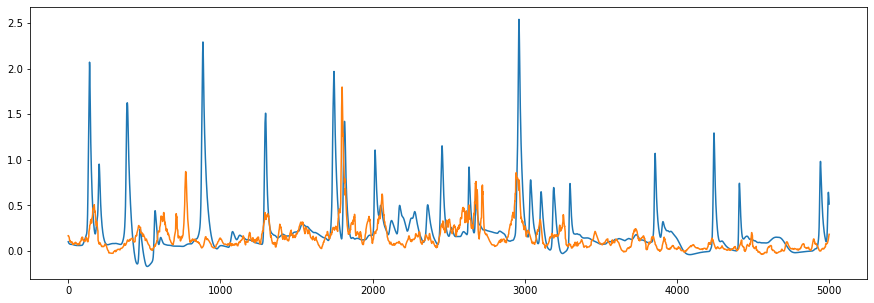

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[20000:25000])
plt.plot(test_V_pred.cpu().detach().numpy()[20000:25000])
#plt.ylim(0,10)
#EXP + EXP

In [8]:
true = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep10_stimseed1.npy")[:,:50000].flatten()[T_train:T_train+T_test]
old = np.load("/media/hdd01/sklee/CA1_clust4-60/alpha_sub6_output.npz")["test"]
new = old + test_V_pred.cpu().detach().numpy()

0.9141887469103781 0.914616685262335


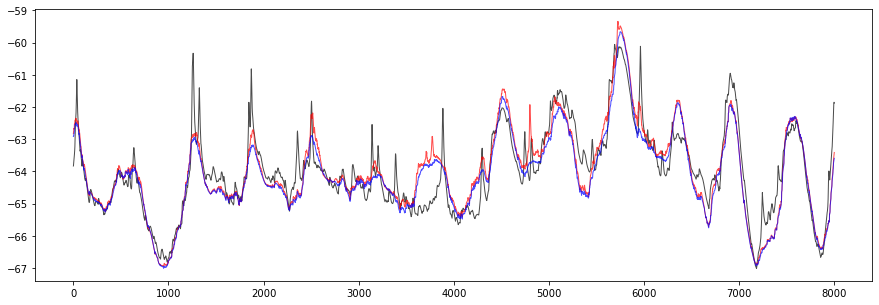

In [9]:
plt.figure(figsize=(15,5))
plt.plot(true[17000:25000], c="black", alpha=0.7, linewidth=1)
plt.plot(new[17000:25000], c="red", alpha=0.7, linewidth=1)
plt.plot(old[17000:25000], c="blue", alpha=0.7, linewidth=1)

new_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=new)
old_score = metrics.explained_variance_score(y_true=true,
                                                      y_pred=old)

print(old_score, new_score)